In [1]:
%matplotlib inline
%load_ext autoreload

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms

In [2]:
%autoreload 1
import taranis.core.nn as ext_nn
from taranis.core.trainer.train import gpu_train, mnist_dataset, gpu_test_model, cifar100_dataset

NOTE: Redirects are currently not supported in Windows or MacOs.


In [3]:
dataset = datasets.MNIST(
    '../data', 
    train=True, 
    download=True
)
print(len(dataset))

image, label = dataset[2]
print(image.size, label)  # A Black and white image is a 2D matrix (28x28)
image

60000
(28, 28) 4


In [4]:
# linear = nn.Sequential(
#     nn.Flatten(),             
#     ext_nn.LinearIdentity(m, n),
#     nn.ReLU(),
#     ext_nn.LinearIdentity(n, m),
# )

# batch = transforms.ToTensor()(image)

# new = linear(batch).detach().view(28, 28).numpy()

# print(new.shape)
# plt.matshow(batch.squeeze(0), interpolation=None, cmap='Greys')
# plt.matshow(new, interpolation=None, cmap='Greys')
# plt.show()

In [5]:
dataset_fast = mnist_dataset()
dataset_test_fast = mnist_dataset(train=False)

# cifar_train = cifar100_dataset(True, True)
# cifar_test = cifar100_dataset(False, True)

In [6]:
classes = 10
dataset = dataset_fast
dataset_test = dataset_test_fast
input_shape = tuple(dataset[0][0].shape)
epoch = 100
m = 1
for d in input_shape:
    m *= d
n = m * 10
lr = 1
lr_map = {0: 2}

print(input_shape, m, n)

(1, 28, 28) 784 7840


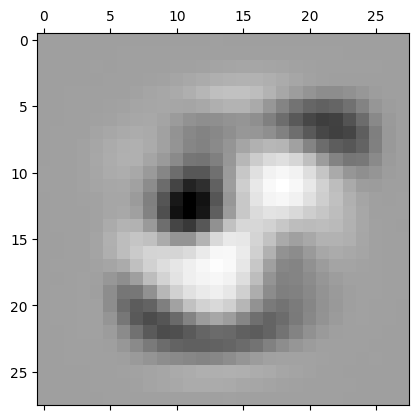

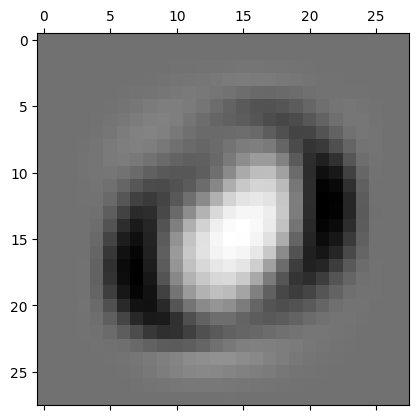

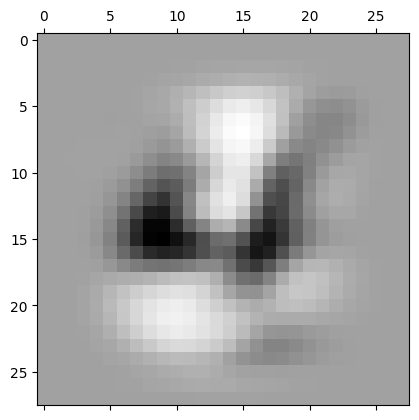

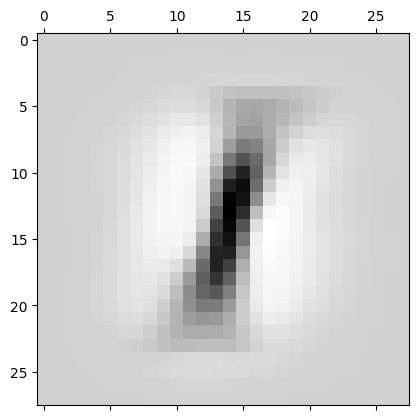

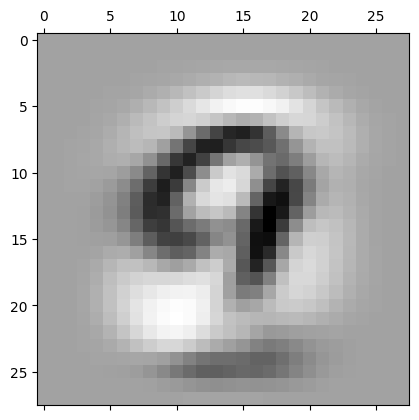

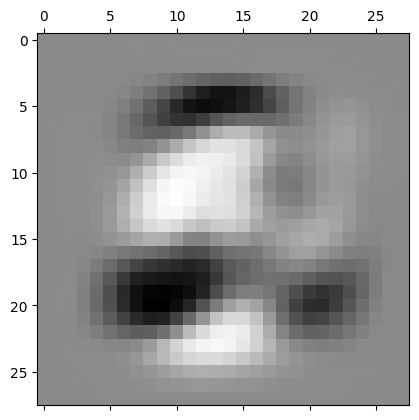

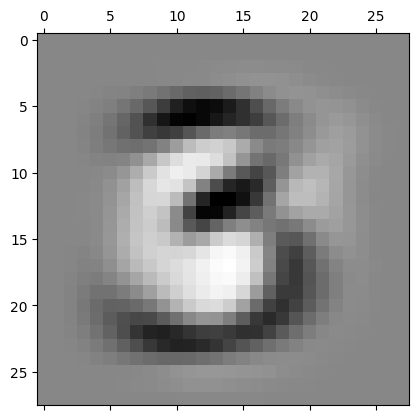

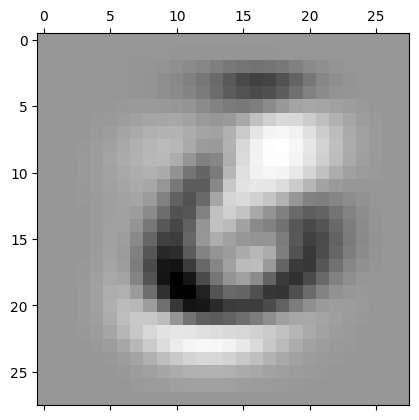

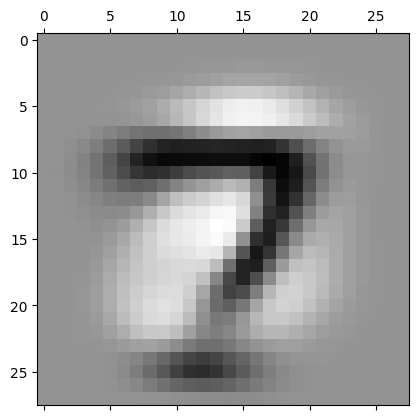

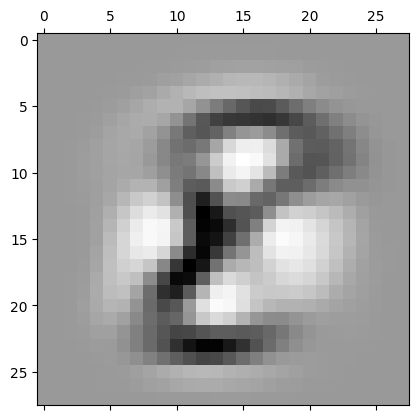

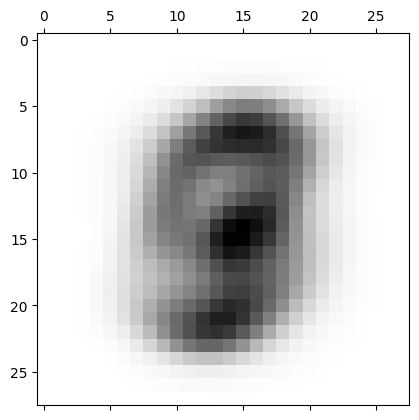

In [76]:
from collections import defaultdict
summary = dict()
total = None
count = defaultdict(int)

for data, target in dataset:
    t = target.item()
    normed = (data - data.min()) / (data.max() - data.min())
    
    if t in summary:
        count[t] += 1
        summary[t] += normed
    else:
        count[t] = 1
        summary[t] = normed.clone()

cnt = 1
for k, data in summary.items():
    data /= count[k]
    data /= data.sum()
    
    if total is None:
        total = data.clone()
    else:
        total += data
        cnt += 1
    
    summary[k] = data

for k, data in summary.items():
    data = data - (total / cnt)
    plt.matshow(data[0], interpolation=None, cmap='Greys')
    plt.show()
    
plt.matshow(total[0], interpolation=None, cmap='Greys')
plt.show()

In [77]:
def init_linear_model(model):
    first_layer = list(model.children())[1]
    
    # torch.Size([78400, 784])
    print(first_layer.weight.shape)

    # first_layer.weight.data /= 1000
    for k, data in summary.items():
        flat = nn.Flatten()(data).squeeze(0)
        first_layer.weight.data[k, :] = flat
        first_layer.weight.data[-k, :] = -flat
        
    # torch.Size([11, 7840])
    second_layer = list(model.children())[3]
    print(second_layer.weight.shape)
    
    # second_layer.weight.data /= 1000
    for k, data in summary.items():
        flat = nn.Flatten()(data).squeeze(0)
        
        for i in flat > 0.5:
            second_layer.weight.data[k, i] = 1

In [78]:
img, target = dataset[0]
r = img.squeeze(0).view(1, 28 * 28) @ summary[target.item()].view(28 * 28, 1)
print(r, r.shape, img.shape)
#plt.matshow(r, interpolation=None, cmap='Greys')
# plt.show()

tensor([[0.9296]]) torch.Size([1, 1]) torch.Size([1, 28, 28])


In [79]:
for i in range(10):
    img, target = dataset[0]
    score = img.squeeze(0).view(1, 28 * 28) @ summary[i].view(28 * 28, 1)
    print(f"- {i}: {score.item()}  truth is {target}")

- 0: 0.6937954425811768  truth is 5
- 1: 0.9750028252601624  truth is 5
- 2: 0.66544109582901  truth is 5
- 3: 0.947245717048645  truth is 5
- 4: 0.5660926103591919  truth is 5
- 5: 0.929560124874115  truth is 5
- 6: 0.7392932772636414  truth is 5
- 7: 0.8423424959182739  truth is 5
- 8: 0.8423006534576416  truth is 5
- 9: 0.7929768562316895  truth is 5


In [7]:
linear = nn.Sequential(
    nn.Flatten(),             
    nn.Linear(m, n),
    nn.ReLU(),
    nn.Linear(n, classes + 1),
    nn.Softmax(dim=1),
)

# linear(summary[0].unsqueeze(0))

# gpu_test_model(linear, dataset)
# init_linear_model(linear)

gpu_test_model(linear, dataset)
# linear(summary[0].unsqueeze(0).cuda()).detach().cpu()
gpu_train(linear, dataset, epoch, lr=lr, lr_map=lr_map)
gpu_test_model(linear, dataset)
gpu_test_model(linear, dataset_test)

Accuracy: 5.963333333333334 Loss: -0.08756698582967122
0 -0.37614983320236206
1 -0.5522608757019043
2 -0.5641342997550964
3 -0.5687888264656067
4 -0.5718346238136292
5 -0.5906236171722412
6 -0.6821941137313843
7 -0.7276666760444641
8 -0.7671729326248169
9 -0.8239890336990356
10 -0.8377562761306763
11 -0.842737078666687
12 -0.8465037941932678
13 -0.8495694398880005
14 -0.852328360080719
15 -0.8547555208206177
16 -0.8569008111953735
17 -0.8588073253631592
18 -0.8605213761329651
19 -0.862092912197113
20 -0.8639401197433472
21 -0.9170387387275696
22 -0.9422025084495544
23 -0.9464079737663269
24 -0.9492205381393433
25 -0.9515438675880432
26 -0.9536412954330444
27 -0.9554791450500488
28 -0.957099974155426
29 -0.9585598707199097
30 -0.9598978161811829
31 -0.9611395001411438
32 -0.9622995853424072
33 -0.9633868932723999
34 -0.964408278465271
35 -0.9653695225715637
36 -0.9662743806838989
37 -0.9671279788017273
38 -0.9679353833198547
39 -0.9687030911445618
40 -0.9694365859031677
41 -0.9701390266

In [41]:
gpu_train(linear, dataset, epoch, lr=1, lr_map=lr_map)
gpu_test_model(linear, dataset)
gpu_test_model(linear, dataset_test)

0 -0.2834213078022003
1 -0.2835705876350403
2 -0.2832164168357849
3 -0.2834380269050598
4 -0.28364163637161255
5 -0.2833617627620697
6 -0.2834387421607971
7 -0.28362786769866943
8 -0.2836761176586151
9 -0.2838168740272522
10 -0.2839691936969757
11 -0.2836759090423584
12 -0.2838389277458191
13 -0.28382840752601624
14 -0.2839893102645874
15 -0.28271496295928955
16 -0.2841891646385193
17 -0.2835276424884796
18 -0.2839496433734894
19 -0.2839280962944031
20 -0.28318309783935547
21 -0.28309762477874756
22 -0.2824574112892151
23 -0.28388261795043945
24 -0.28357207775115967
25 -0.2841475307941437
26 -0.28321540355682373
27 -0.2838843762874603
28 -0.28371259570121765
29 -0.2838670015335083
30 -0.28409141302108765
31 -0.28405413031578064
32 -0.28389543294906616
33 -0.2835678458213806
34 -0.28437039256095886
35 -0.28419986367225647
36 -0.2841571867465973
37 -0.2847200930118561
38 -0.2839224338531494
39 -0.28389686346054077
40 -0.2844119071960449
41 -0.2837856113910675
42 -0.28447139263153076
43 -

KeyboardInterrupt: 

In [8]:
import importlib
import taranis
import taranis.core.visualization.extract as extract
importlib.reload(taranis.core.visualization.extract)

<module 'taranis.core.visualization.extract' from 'e:\\work\\taranis\\taranis\\core\\visualization\\extract.py'>

0


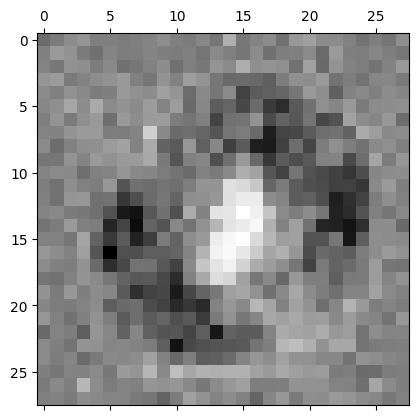

1


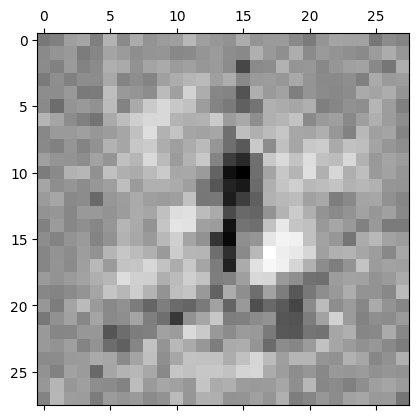

2


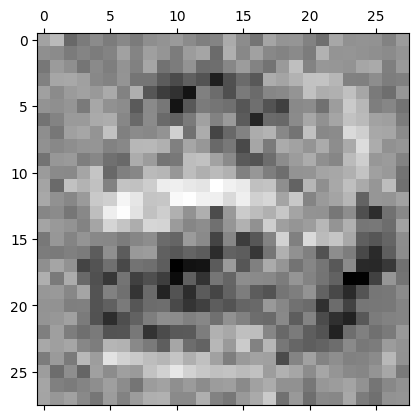

3


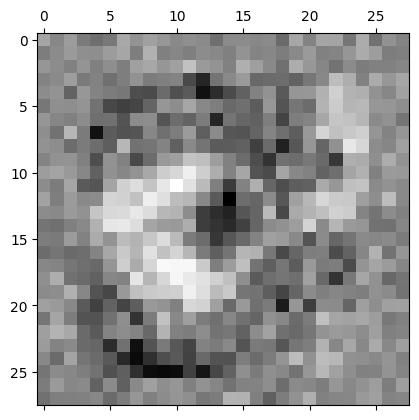

4


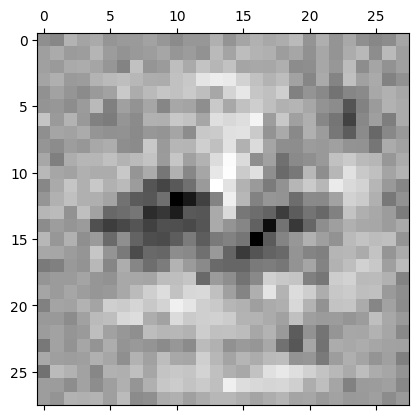

5


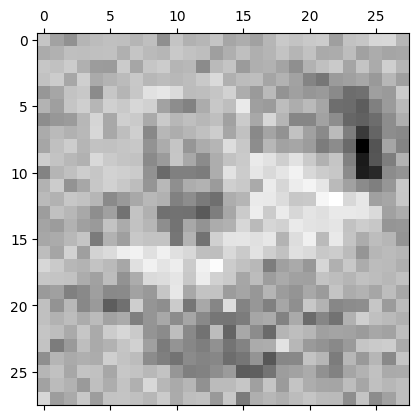

6


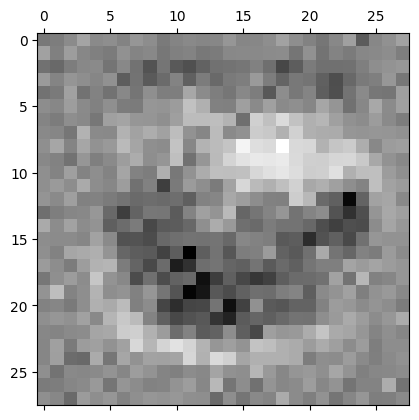

7


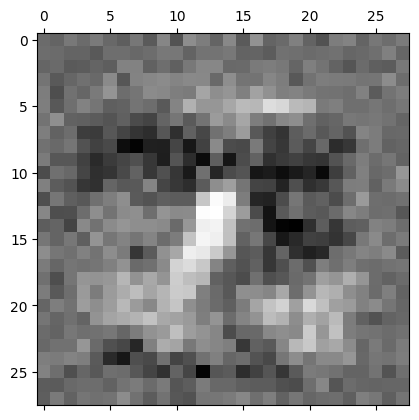

8


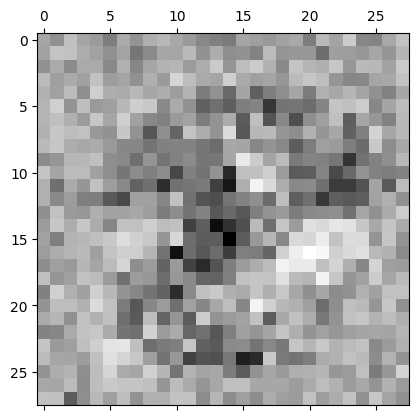

9


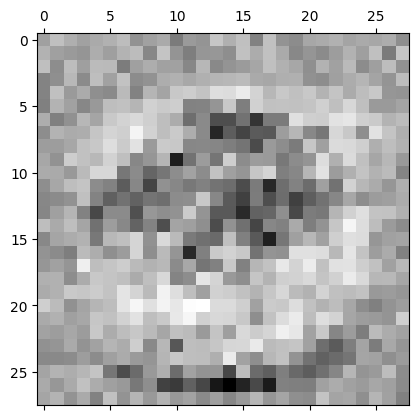

10


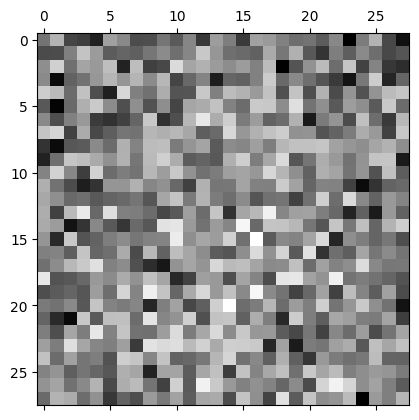

In [9]:
for i in range(11):
    print(i)
    img = extract.generate_image(linear, input_shape, i, 10, 0.9999)
    plt.matshow(img[0][0], interpolation=None, cmap='Greys')
    plt.show()

In [16]:
original, label = dataset[0]

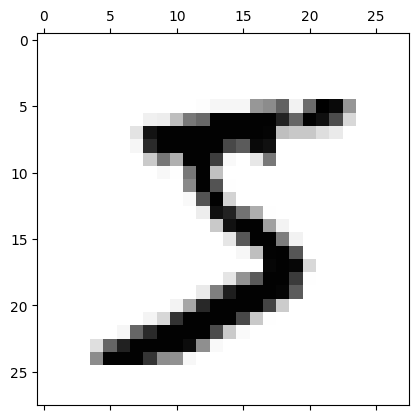

tensor([[5]], device='cuda:0')

In [17]:
plt.matshow(original[0], interpolation=None, cmap='Greys')
plt.show()
output = linear(original.cuda())
output.argmax(dim=1, keepdim=True) 

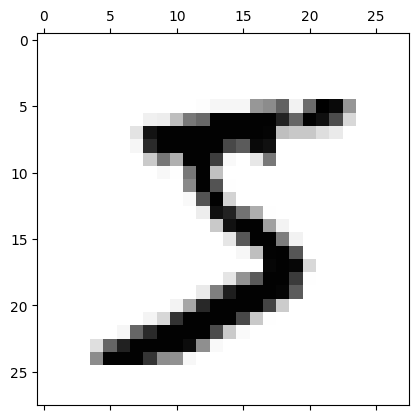

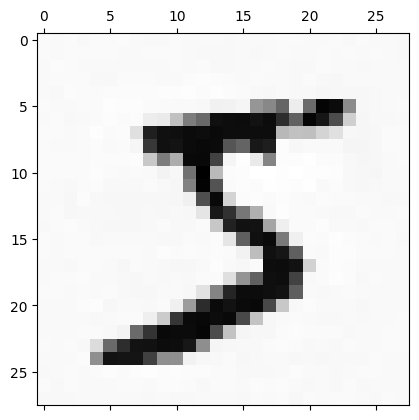

1.5109164746619963e-19


In [36]:
plt.matshow(original[0], interpolation=None, cmap='Greys')
plt.show()

img, confidence = extract.tweak_image(linear, original, 4, 10, 0.990, max_iter=10000)

plt.matshow(img, interpolation=None, cmap='Greys')
plt.show()

print(confidence)

tensor(-0.3089) tensor(0.1999)


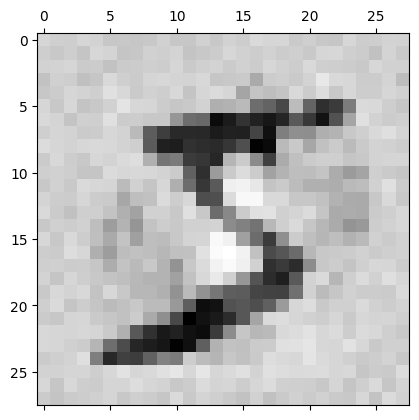

tensor([[5]], device='cuda:0')

In [24]:
img = extract.generate_image(linear, input_shape, 0, 10, 0.9999)[0]
print(img.min(), img.max())

original_min = original.min()
original_max = original.max()
original_range = original_max - original_min

img_min = img.min()
img_max = img.max()
img_range = img_max - img_min

img = ((img - img_min) / img_range) * original_range + original_min

p = 0.50
adversarial = original * (1 - p) + img * p
plt.matshow(adversarial[0], interpolation=None, cmap='Greys')
plt.show()


output = linear(adversarial.cuda())
output.argmax(dim=1, keepdim=True) 

In [33]:
import taranis.core.nn as ext_nn

linear = nn.Sequential(
    nn.Flatten(),             
    ext_nn.LinearIdentity(m, n),
    nn.ReLU(),
    ext_nn.LinearIdentity(n, classes),
    nn.Softmax(dim=1),
)

gpu_train(linear, dataset, 100, lr=lr, lr_map=lr_map)
gpu_test_model(linear, dataset)
gpu_test_model(linear, dataset_test)

0 -0.025855847199757895
1 -0.03305356502532959
2 -0.0333518385887146
3 -0.03350720405578613
4 -0.0336058775583903
5 -0.033682103951772055
6 -0.033739880720774336
7 -0.0337876836458842
8 -0.033828870455423994
9 -0.03386344909667969
10 -0.03389474153518677
11 -0.033921349048614505
12 -0.033944257100423175
13 -0.033961776892344156
14 -0.03397780259450277
15 -0.03399474223454793
16 -0.034009210268656415
17 -0.034020551045735675
18 -0.0340305765469869
19 -0.034040276209513345
20 -0.0340502659479777
21 -0.03406020005544027
22 -0.03406988382339478
23 -0.03407861391703288
24 -0.03408615191777547
25 -0.034093423684438066
26 -0.03410022258758545
27 -0.03410675128300985
28 -0.034113192558288576
29 -0.03411925236384074
30 -0.034125296274820964
31 -0.034131773312886554
32 -0.03413831392923991
33 -0.03414405981699626
34 -0.03414921760559082
35 -0.034153703848520914
36 -0.034157633781433105
37 -0.034161420663197835
38 -0.03416534662246704
39 -0.03416927258173625
40 -0.03417319854100545
41 -0.03417684

KeyboardInterrupt: 

In [34]:
import math

linear = nn.Sequential(
    ext_nn.MaskLayer(input_shape, True),
    nn.Flatten(),             
    nn.Linear(m, n),
    nn.ReLU(),
    nn.Linear(n, 10),
    nn.Softmax(dim=1),
)
# nn.init.kaiming_uniform_(list(linear.children())[0].weight, a=math.sqrt(5))

gpu_train(linear, dataset, epoch, lr=lr, lr_map=lr_map)
gpu_test_model(linear, dataset)
gpu_test_model(linear, dataset_test)

0 -0.006673250099023183
1 -0.006693302094936371
2 -0.006725814441839854
3 -0.006791658202807109
4 -0.006949969132741292
5 -0.007450894514719645
6 -0.01029404600461324
7 -0.015508286158243815
8 -0.026666657129923502
9 -0.03587265809377035
10 -0.04214041630427043
11 -0.04457614421844482
12 -0.045877838134765626
13 -0.04671330054601033
14 -0.04766329526901245
15 -0.050970753033955894
16 -0.05199408928553263
17 -0.052573045094807945
18 -0.052996317545572914
19 -0.053338428338368736
20 -0.05362682342529297
21 -0.05387606223424276
22 -0.05409533580144246
23 -0.0542911171913147
24 -0.05446806351343791
25 -0.05462963581085205
26 -0.05477875868479411
27 -0.05491885741551717
28 -0.05505885283152263
29 -0.05538970629374186
30 -0.05722528298695882
31 -0.05850963592529297
32 -0.058987804253896076
33 -0.059304277102152504
34 -0.05955933729807536
35 -0.059779131412506105
36 -0.059975095589955646
37 -0.06015317440032959
38 -0.060316729545593264
39 -0.06046823263168335
40 -0.060609809557596844
41 -0.06

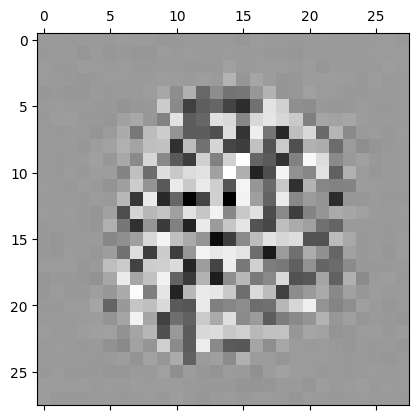

In [35]:
plt.matshow(list(linear.children())[0].weight[0].detach().cpu(), interpolation=None, cmap='Greys')
plt.show()

In [16]:
linear = nn.Sequential(
    ext_nn.MaskLayer(input_shape, True),
    nn.Flatten(),             
    ext_nn.LinearIdentity(m, n),
    nn.ReLU(),
    ext_nn.LinearIdentity(n, 10),
    nn.Softmax(dim=1),
)
          
gpu_train(linear, dataset, epoch, lr=lr, lr_map=lr_map)
gpu_test_model(linear, dataset)
gpu_test_model(linear, dataset_test)

0 -0.0066677391529083255
1 -0.006668297946453095
2 -0.006668853759765625
3 -0.0066694115598996484
4 -0.006669969856739044
5 -0.00667052815357844
6 -0.006671087940533956
7 -0.006671648720900218
8 -0.00667220950126648
9 -0.006672769784927368
10 -0.006673331061999003
11 -0.006673892339070638
12 -0.006674454112847646
13 -0.006675017873446146
14 -0.006675581137339274
15 -0.006676144401232402
16 -0.006676707168420156
17 -0.006677271922429403
18 -0.006677836179733276
19 -0.006678399940331777
20 -0.006678963204224905
21 -0.006679527461528778
22 -0.006680091222127278
23 -0.0066806554794311525
24 -0.006681221723556519
25 -0.006681787967681885
26 -0.006682356695334116
27 -0.006682927906513214
28 -0.0066835001111030575
29 -0.0066840743025143945
30 -0.006684649487336477
31 -0.006685227652390798
32 -0.006685807804266612


KeyboardInterrupt: 

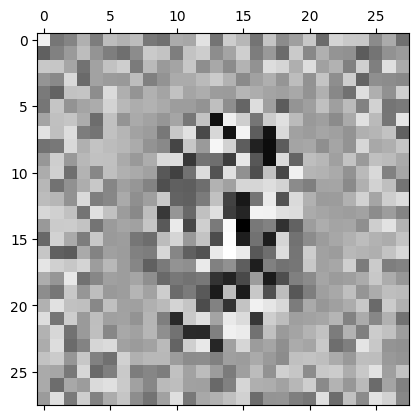

In [13]:
plt.matshow(list(linear.children())[0].weight.detach().cpu(), interpolation=None, cmap='Greys')
plt.show()

In [14]:
list(linear.children())[0].weight.min()

tensor(-0.1497, device='cuda:0', grad_fn=<MinBackward1>)

In [14]:
# mnist_dataset()

In [10]:
dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size = 128,
        num_workers = 0,
    )

In [11]:
b = next(iter(dataloader))
b

[tensor([[[[ 1.8431,  1.8431,  1.8431,  ...,  0.9633,  1.2126,  0.7727],
           [ 1.8431,  1.8284,  1.8284,  ...,  0.5968,  0.4648,  0.2449],
           [ 1.8431,  1.8284,  1.8431,  ...,  0.8754,  0.5381, -0.1217],
           ...,
           [ 0.2742,  0.1862,  0.1569,  ..., -1.4560, -0.9428, -0.7815],
           [-0.1070, -0.1364, -0.0484,  ..., -1.5733, -0.4736,  0.1716],
           [-0.6202, -0.6056, -0.4150,  ..., -1.3974, -0.3563,  0.1276]],
 
          [[ 2.0015,  2.0015,  2.0015,  ...,  1.2370,  1.5275,  1.0688],
           [ 2.0015,  1.9862,  1.9862,  ...,  0.7936,  0.6713,  0.4572],
           [ 2.0015,  1.9862,  2.0015,  ...,  1.1453,  0.8242,  0.1361],
           ...,
           [ 0.9312,  0.8853,  0.8394,  ..., -1.6376, -0.9495, -0.7202],
           [ 0.5031,  0.4725,  0.5489,  ..., -1.6529, -0.1850,  0.5642],
           [-0.0321, -0.0321,  0.1514,  ..., -1.3471,  0.1361,  0.7477]],
 
          [[ 2.0256,  2.0256,  2.0256,  ...,  1.1449,  1.3011,  0.7756],
           [ 

In [13]:
l = ext_nn.MaskLayer(input_shape).cuda()

In [16]:
b[0].shape

torch.Size([128, 3, 32, 32])

In [18]:
l(b[0]).mean()

tensor(0., device='cuda:0', grad_fn=<MeanBackward0>)